# Import

In [1]:
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.datasets
import sklearn.model_selection

np.set_printoptions(precision=4)

%matplotlib inline

# Load Digits dataset

In [2]:
# Load Digits dataset
X, y = sklearn.datasets.load_digits(return_X_y=True)

# show shapes and number of classes
X.shape, y.shape, np.unique(y)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

# Apply standard scaler to raw data

In [3]:
scaler = sklearn.preprocessing.StandardScaler()
X_transform = scaler.fit_transform(X)

# LDA (Linear Discriminant Analysis)

![](images/lda_1.png)

Future reading:

- https://en.wikipedia.org/wiki/Linear_discriminant_analysis
- https://sebastianraschka.com/Articles/2014_python_lda.html
- https://github.com/bot13956/linear-discriminant-analysis-iris-dataset/blob/master/LDA_irisdataset.ipynb
- https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis


# Within-class scatter matrix

In [4]:
def within_class_scatter_matrices(X, y):

    shape = X.shape[1]
    matrix = np.zeros((shape, shape))
    
    for i in np.unique(y):
        matrix += np.cov(X[y == i].T)
        
    return matrix

In [5]:
wc = within_class_scatter_matrices(X_transform, y)

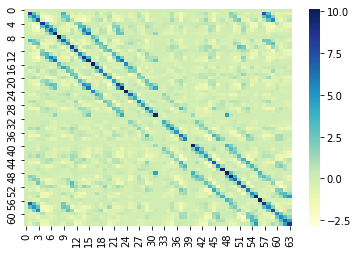

In [6]:
# visualize matrix
_ = sns.heatmap(wc, cmap="YlGnBu")

# Between-class scatter matrix

In [7]:
def between_class_scatter_matrix(X, y):
    
    mean_vectors = []
    for i in np.unique(y):
        mean_vectors.append(np.mean(X[y == i], axis=0))
    
    overall_mean = np.mean(X, axis=0)

    shape = X.shape[1]
    matrix = np.zeros((shape, shape))
    for i, mean_vec in enumerate(mean_vectors):  
        n = X[y == i + 1,:].shape[0]
        mean_vec = mean_vec.reshape(shape, 1) # make column vector
        overall_mean = overall_mean.reshape(shape, 1) # make column vector
        matrix += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
        
    return matrix


In [8]:
bc = between_class_scatter_matrix(X_transform, y)

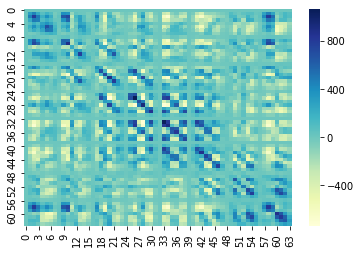

In [9]:
_ = sns.heatmap(bc, cmap="YlGnBu")

# Solving the generalized eigenvalue problem

In [10]:
A = np.linalg.pinv(wc).dot(bc)

eig_vals, eig_vecs = np.linalg.eig(A)

In [11]:
eig_vals.shape, eig_vecs.shape

((64,), (64, 64))

# Sorting the eigenvectors by decreasing eigenvalues

In [12]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# maximum explained variance
eig_sum = sum([x[0] for x in eig_pairs])

# show top 10 eigenvalue
cumsum = 0.
for i in range(10):
    rel_value = eig_pairs[i][0] / eig_sum * 100
    print('component : {:2} cumsum variance explained : {:5.1f}%'.format(i + 1, rel_value + cumsum))
    cumsum += rel_value

component :  1 cumsum variance explained :  30.3%
component :  2 cumsum variance explained :  49.3%
component :  3 cumsum variance explained :  66.5%
component :  4 cumsum variance explained :  78.4%
component :  5 cumsum variance explained :  85.5%
component :  6 cumsum variance explained :  92.3%
component :  7 cumsum variance explained :  96.8%
component :  8 cumsum variance explained :  99.7%
component :  9 cumsum variance explained : 100.0%
component : 10 cumsum variance explained : 100.0%


# Choosing k eigenvectors with the largest eigenvalues

In [13]:
n_components = 2

# create W
shape = X_transform.shape[1]
W = np.hstack([eig_pairs[component][1].reshape(shape, 1) for component in range(n_components)])
print('Matrix W:', W.shape)

Matrix W: (64, 2)


# Transforming the samples onto the new subspace

In [14]:
X_lda = X_transform.dot(W)

# Create custom LDA class

In [15]:
%%writefile lda.py

import numpy as np


class LDA(object):
    
    def __init__(self, n_components):
        self.n_components = n_components
    
    def _within_class_scatter_matrices(self, X, y):

        shape = X.shape[1]
        matrix = np.zeros((shape, shape))

        for i in np.unique(y):
            matrix += np.cov(X[y == i].T)

        return matrix
    
    def _between_class_scatter_matrix(self, X, y):
    
        mean_vectors = []
        for i in np.unique(y):
            mean_vectors.append(np.mean(X[y == i], axis=0))

        overall_mean = np.mean(X, axis=0)

        shape = X.shape[1]
        matrix = np.zeros((shape, shape))
        for i, mean_vec in enumerate(mean_vectors):  
            n = X[y == i + 1,:].shape[0]
            mean_vec = mean_vec.reshape(shape, 1)
            overall_mean = overall_mean.reshape(shape, 1)
            matrix += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

        return matrix
    
    def _create_eig_values_and_vectors(self, X, y):
        
        wc = self._within_class_scatter_matrices(X, y)
        bc = self._between_class_scatter_matrix(X, y)
        
        A = np.linalg.pinv(wc).dot(bc)

        eig_vals, eig_vecs = np.linalg.eig(A)
        
        return eig_vals, eig_vecs
    
    def fit(self, X, y):
        
        eig_vals, eig_vecs = self._create_eig_values_and_vectors(X, y)
        
        # Make a list of (eigenvalue, eigenvector) tuples
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
        
        shape = X.shape[1]
        self.W = np.hstack([eig_pairs[comp][1].reshape(shape, 1) for comp in range(self.n_components)])
        
        return self
    
    def transform(self, X, y):
        return X.dot(self.W).real
    
    def fit_transform(self, X, y):
        self = self.fit(X, y)
        return self.transform(X, y)

    

Overwriting lda.py


In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
import lda

lda = lda.LDA(n_components=2)
X_lda = lda.fit_transform(X_transform, y)

In [18]:
data = pd.DataFrame(X_lda, columns=['LDA1', 'LDA2'])
data['label'] = y
data.head()

,LDA1,LDA2,label
0,1.444130,-2.996487,0
1,-0.301005,1.654195,1
2,-1.589269,0.650409,2
3,-1.628599,-0.462097,3
4,3.402239,1.086859,4


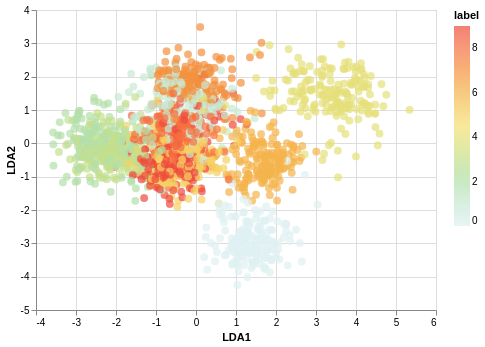

In [19]:
chart_lda = alt.Chart(data).mark_circle(size=60).encode(
    x='LDA1',
    y='LDA2',
    color=alt.Color('label', scale=alt.Scale(scheme='lightmulti')),
)

chart_lda.interactive()

# Compare with PCA

In [20]:
pca = sklearn.decomposition.PCA(n_components=10)
X_pca = pca.fit_transform(X_transform)

In [21]:
for i, ratio in enumerate(pca.explained_variance_ratio_.cumsum()):
    print('component : {:2} cumsum variance explained : {:5.1f}%'.format(i + 1, ratio * 100))

component :  1 cumsum variance explained :  12.0%
component :  2 cumsum variance explained :  21.6%
component :  3 cumsum variance explained :  30.0%
component :  4 cumsum variance explained :  36.5%
component :  5 cumsum variance explained :  41.4%
component :  6 cumsum variance explained :  45.6%
component :  7 cumsum variance explained :  49.6%
component :  8 cumsum variance explained :  52.9%
component :  9 cumsum variance explained :  55.9%
component : 10 cumsum variance explained :  58.9%


In [22]:
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]
data.head()

,LDA1,LDA2,label,PCA1,PCA2
0,1.444130,-2.996487,0,1.914225,-0.954613
1,-0.301005,1.654195,1,0.589034,0.924777
2,-1.589269,0.650409,2,1.302081,-0.317240
3,-1.628599,-0.462097,3,-3.020786,-0.868870
4,3.402239,1.086859,4,4.528733,-1.093358


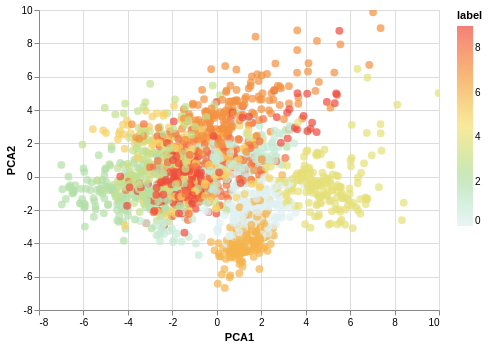

In [23]:
chart_pca = alt.Chart(data).mark_circle(size=60).encode(
    x='PCA1',
    y='PCA2',
    color=alt.Color('label', scale=alt.Scale(scheme='lightmulti')),
)

chart_pca.interactive()

# Combine together

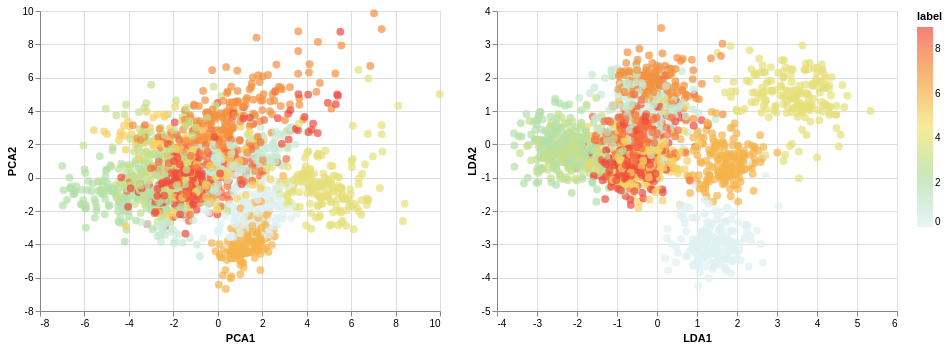

In [24]:
chart_pca | chart_lda

# Compare with LDA from sklearn

In [25]:
import sklearn.discriminant_analysis

lda_sklearn = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
X_lda_sk = lda.fit_transform(X_transform, y)

In [26]:
data['LDA_sklearn1'] = X_lda_sk[:, 0]
data['LDA_sklearn2'] = X_lda_sk[:, 1]
data.head()

,LDA1,LDA2,label,PCA1,PCA2,LDA_sklearn1,LDA_sklearn2
0,1.444130,-2.996487,0,1.914225,-0.954613,1.444130,-2.996487
1,-0.301005,1.654195,1,0.589034,0.924777,-0.301005,1.654195
2,-1.589269,0.650409,2,1.302081,-0.317240,-1.589269,0.650409
3,-1.628599,-0.462097,3,-3.020786,-0.868870,-1.628599,-0.462097
4,3.402239,1.086859,4,4.528733,-1.093358,3.402239,1.086859


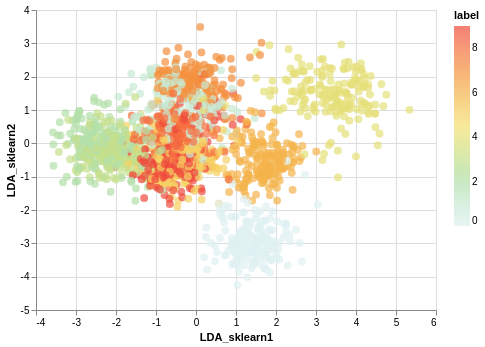

In [27]:
chart_lda_sklearn = alt.Chart(data).mark_circle(size=60).encode(
    x='LDA_sklearn1',
    y='LDA_sklearn2',
    color=alt.Color('label', scale=alt.Scale(scheme='lightmulti')),
)

chart_lda_sklearn.interactive()

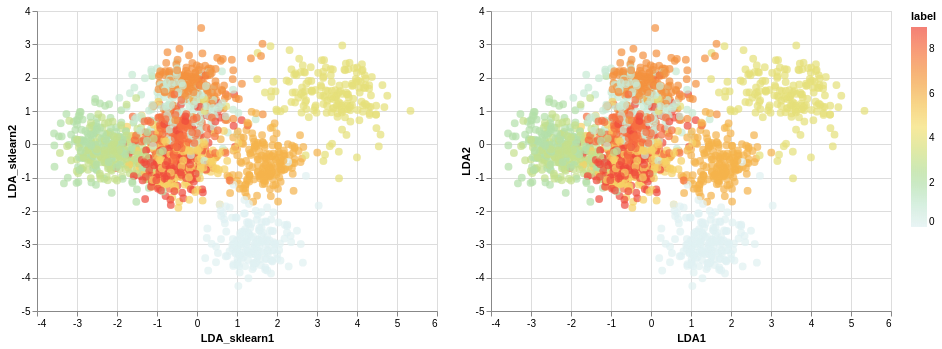

In [28]:
chart_lda_sklearn | chart_lda